In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from prettytable import PrettyTable

# Data for the table
data = [
    {"Speaker": 1, "Accuracy": 1.000000},
    {"Speaker": 5, "Accuracy": 0.833333},
    {"Speaker": 2, "Accuracy": 0.800000},
    {"Speaker": 3, "Accuracy": 0.733333},
    {"Speaker": 0, "Accuracy": 0.625000},
    {"Speaker": 4, "Accuracy": 0.500000},
]

# Create a PrettyTable object
table = PrettyTable()
table.field_names = ["Speaker", "Accuracy"]

# Add rows to the table
for row in data:
    table.add_row([row["Speaker"], row["Accuracy"]])

# Styling options
table.align = "c"  # Center align the columns

# Print the table
print(table)


+---------+----------+
| Speaker | Accuracy |
+---------+----------+
|    1    |   1.0    |
|    5    | 0.833333 |
|    2    |   0.8    |
|    3    | 0.733333 |
|    0    |  0.625   |
|    4    |   0.5    |
+---------+----------+


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pickle


In [ ]:
dataset_path = '/content/drive/MyDrive/PFA/Speaker_dataset'

# Hyperparameters
n_mfcc = 13         # Number of MFCC features
max_pad_len = 100   # Pad or truncate MFCCs to this length
batch_size = 64     # Optimized batch size for batch processing

<ipython-input-6-e6d6e68b637e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x='Speaker', y='Num_Audio_Files', palette='magma')


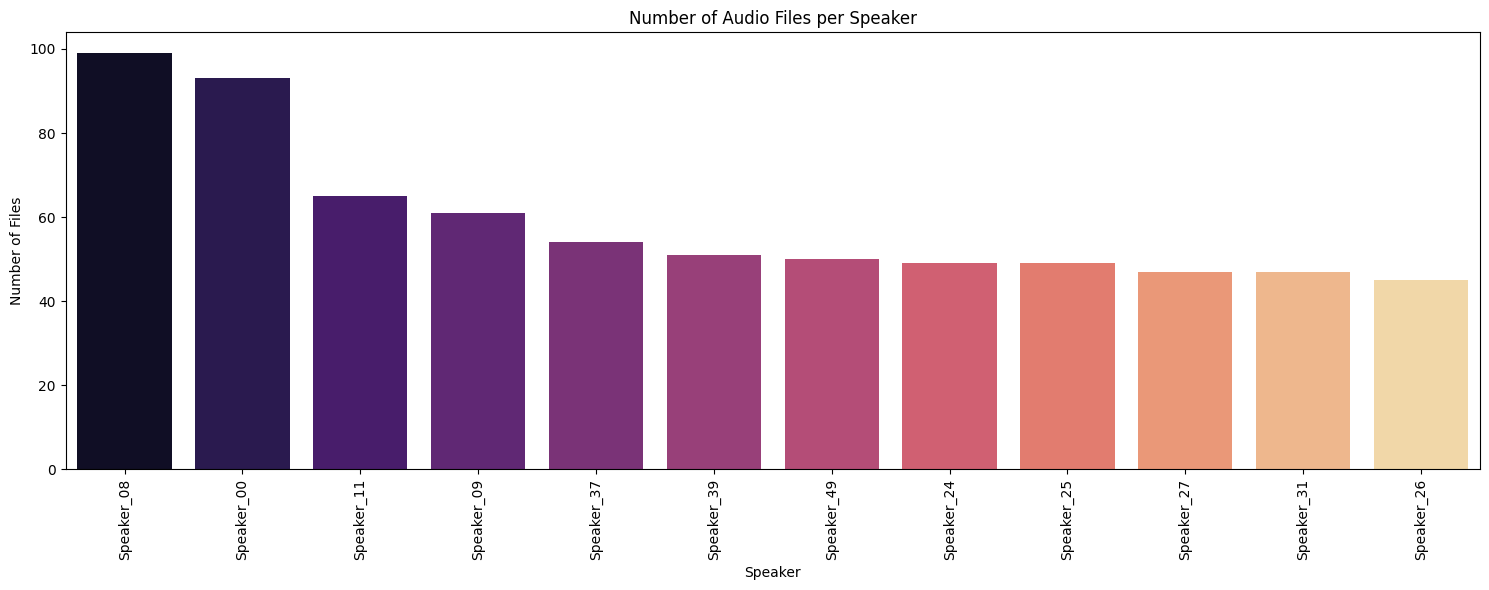

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Count audio files per speaker
speaker_counts = {
    speaker: len([f for f in os.listdir(os.path.join(dataset_path, speaker)) if f.endswith('.wav')])
    for speaker in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, speaker))
}

# Convert to DataFrame
df_counts = pd.DataFrame(list(speaker_counts.items()), columns=['Speaker', 'Num_Audio_Files'])
df_counts = df_counts.sort_values(by='Num_Audio_Files', ascending=False)

# Plot
plt.figure(figsize=(15, 6))
sns.barplot(data=df_counts, x='Speaker', y='Num_Audio_Files', palette='magma')
plt.xticks(rotation=90)
plt.title('Number of Audio Files per Speaker')
plt.xlabel('Speaker')
plt.ylabel('Number of Files')
plt.tight_layout()
plt.show()


# 1.Preprocessing

In [ ]:
def extract_mfcc_features(audio, sample_rate, n_mfcc=n_mfcc, max_pad_len=max_pad_len):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    if mfccs is None or len(mfccs) == 0:
        print("Warning: MFCC extraction returned None or empty array.")
        return None
    mfccs = np.pad(mfccs, ((0, 0), (0, max(0, max_pad_len - mfccs.shape[1]))), mode='constant')
    return mfccs[:, :max_pad_len]

In [ ]:
def augment_audio(audio):
    speed_change = np.random.uniform(0.9, 1.1)
    augmented_audio = librosa.effects.time_stretch(audio, rate=speed_change)
    noise = np.random.randn(len(augmented_audio)) * 0.005
    augmented_audio += noise
    return augmented_audio

In [ ]:
features = []
labels = []

for speaker in os.listdir(data_path):
    speaker_folder = os.path.join(data_path, speaker)
    if os.path.isdir(speaker_folder):
        for file_name in os.listdir(speaker_folder):
            file_path = os.path.join(speaker_folder, file_name)
            audio, sample_rate = librosa.load(file_path, sr=None)
            if audio is None or len(audio) == 0:
                print(f"Warning: Audio file {file_path} could not be loaded.")
                continue
            mfcc_features = extract_mfcc_features(audio, sample_rate)
            if mfcc_features is not None:
                features.append(mfcc_features)
                labels.append(speaker)

                # Augment and extract features for the augmented audio
                augmented_audio = augment_audio(audio)
                augmented_mfcc = extract_mfcc_features(augmented_audio, sample_rate)
                if augmented_mfcc is not None:
                    features.append(augmented_mfcc)
                    labels.append(speaker)

In [ ]:
# Convert features and labels to numpy arrays
X = np.array(features)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# 2.Model training

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_mfcc, max_pad_len, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

    tf.keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.9889 - loss: 0.0470 - val_accuracy: 0.8908 - val_loss: 0.3575 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.9865 - loss: 0.0580 - val_accuracy: 0.9648 - val_loss: 0.1247 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.9903 - loss: 0.0463 - val_accuracy: 0.9472 - val_loss: 0.1609 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.9909 - loss: 0.0376 - val_accuracy: 0.9542 - val_loss: 0.1708 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.9937 - loss: 0.0351 - val_accuracy: 0.9613 - val_loss: 0.1933 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.9981 - loss: 0.0201 - val_accuracy: 0.9683 - val_loss: 0.1137 - learning_rate: 5.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.9962 - loss

In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9879 - loss: 0.0508
Test Accuracy: 98.59%


Using a functional API approach rather than sequential for the flexibility

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

# Define the input tensor
input_tensor = Input(shape=(n_mfcc, max_pad_len, 1))

# Build the convolutional layers
x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

# Build the dense layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Define the output layer
output_tensor = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Create the model
functional_model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
functional_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary to verify
functional_model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 13, 100, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 100, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 100, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 50, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 50, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 50, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 25, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 25, 128)          │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 25, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,668 (276.05 KB)

 Trainable params: 70,220 (274.30 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train the model
history = functional_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 326ms/step - accuracy: 0.3074 - loss: 2.1919 - val_accuracy: 0.2465 - val_loss: 2.5087 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.5808 - loss: 1.4432 - val_accuracy: 0.3204 - val_loss: 2.0233 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.7215 - loss: 1.0271 - val_accuracy: 0.5000 - val_loss: 1.6977 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.8160 - loss: 0.7672 - val_accuracy: 0.5986 - val_loss: 1.4682 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.8629 - loss: 0.5305 - val_accuracy: 0.6585 - val_loss: 1.3080 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.9203 - loss: 0.3592 - val_accuracy: 0.6725 - val_loss: 1.1242 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.9309 - loss: 0

# 3.Model evaluation (CNN as feature extractor)

In [ ]:
# Evaluate model
test_loss, test_accuracy = functional_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9704 - loss: 0.1316
Test Accuracy: 97.18%


In [ ]:
functional_model.save('/content/drive/MyDrive/PFA/cnn_audio_classifier.keras')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/PFA/cnn_audio_classifier.keras')


# 4.Building the submodel for embeddings

In [ ]:
functional_model(X_train[:1])

<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[2.5616205e-06, 1.1403806e-03, 9.9881601e-01, 2.1240508e-06,
        1.1872668e-05, 1.5418956e-06, 5.1083092e-08, 1.0448187e-05,
        7.2264056e-06, 3.7175794e-06, 3.5881512e-06, 6.2694681e-07]],
      dtype=float32)>

In [ ]:
X.shape#checking if the shape matches the input shape

(1420, 13, 100, 1)

In [ ]:
from tensorflow.keras.models import Model

# Extract embeddings from the 'dense_2' layer
embedding_model = Model(inputs=functional_model.input, outputs=functional_model.get_layer('dense_2').output)

print("Embeddings shape:", X_embeddings.shape)

Embeddings shape: (1136, 128)


In [ ]:
# Extract embeddings for the entire training dataset at once
X_embeddings = embedding_model.predict(X_train, verbose=1)

# Flatten the embeddings (if needed)
X_embeddings = X_embeddings.reshape(X_embeddings.shape[0], -1)  # Shape: (num_samples, 128)

# Convert labels back to their original form if necessary
y_speakers = np.argmax(y_train, axis=1)  # If y_train is categorical, decode it to class indices

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [ ]:
#Normalizing the embeddings
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_embeddings_normalized = scaler.fit_transform(X_embeddings)

X_test_embeddings = embedding_model.predict(X_test)
X_test_embeddings_normalized = scaler.transform(X_test_embeddings)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [ ]:
y_speakers = np.argmax(y_train, axis=1)

In [ ]:
from collections import defaultdict

# Step 6: Group embeddings by speaker
speaker_embeddings = defaultdict(list)
for embedding, label in zip(X_embeddings_normalized, y_speakers):
    speaker_embeddings[label].append(embedding)


# 5.Training the GMM models on the embeddings

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Create and train GMMs for each speaker
gmm_models = {}
for speaker, embeddings in speaker_embeddings.items():
    embeddings_array = np.array(embeddings)  # Convert to a NumPy array

    if len(embeddings_array) < 10:  # Ensure enough samples exist
        print(f"Warning: Speaker {speaker} has only {len(embeddings_array)} samples. Adjusting components.")
        n_components = min(5, len(embeddings_array))  # Reduce components if needed
    else:
        n_components = 3  # Use a higher value if there are enough samples

    gmm = GaussianMixture(n_components=n_components, covariance_type='diag', random_state=42, init_params="kmeans")
    gmm.fit(embeddings_array)  # Train the GMM
    gmm_models[speaker] = gmm  # Store the GMM for the speaker

In [ ]:
print("Test embeddings shape:", embedding_model.predict(X_test).shape)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Test embeddings shape: (284, 128)


# 6.Model evaluation

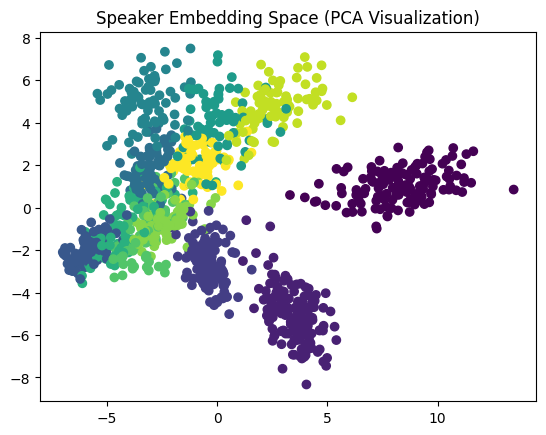

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(X_embeddings)  # Use training embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_speakers, cmap='viridis')
plt.title("Speaker Embedding Space (PCA Visualization)")
plt.show()

In [ ]:
def predict_speaker(audio_mfcc):
  audio_mfcc=audio_mfcc.reshape(1,n_mfcc,max_pad_len,1)
  embedding=embedding_model.predict(audio_mfcc,verbose=0).flatten()
  scores={}
  for speaker,gmm in gmm_models.items():
    score=gmm.score([embedding])
    scores[speaker]=score
    return max(scores, key=lambda speaker: scores[speaker])

In [ ]:
correct = 0
total = 0

for mfcc, true_label in zip(X_test, y_test):
    pred_label = predict_speaker(mfcc)
    true_label = np.argmax(true_label)
    if pred_label == true_label:
        correct += 1
    total += 1

accuracy = correct / total
print(f"GMM Accuracy: {accuracy * 100:.2f}%")



GMM Accuracy: 6.69%


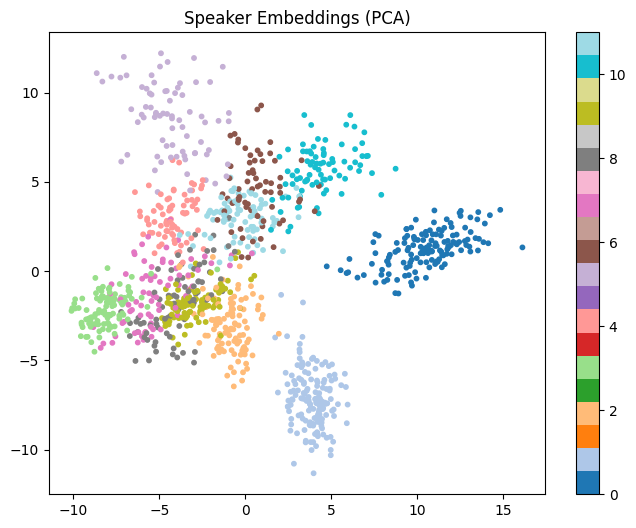

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(X_embeddings_normalized)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=y_speakers, cmap='tab20', s=10)
plt.title("Speaker Embeddings (PCA)")
plt.colorbar()
plt.show()


In [ ]:
print("Unique labels in y_speakers:", np.unique(y_speakers))
print("Unique labels in y_test:", np.unique(np.argmax(y_test, axis=1)))


Unique labels in y_speakers: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Unique labels in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11]


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


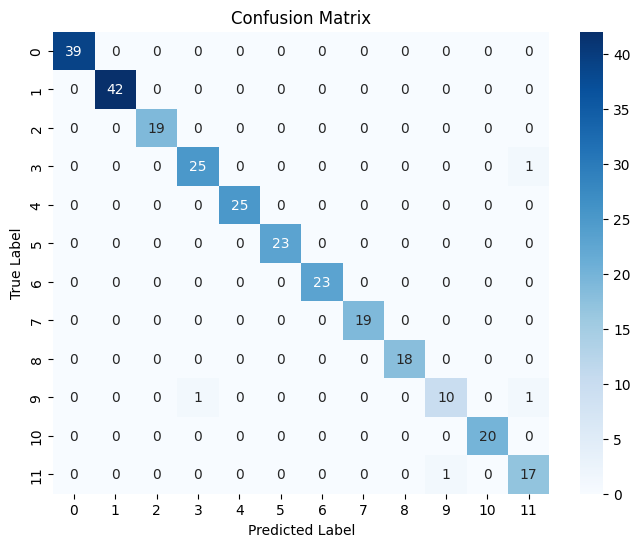

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot it
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_embeddings_normalized, y_speakers)
y_knn_pred = knn.predict(X_test_embeddings_normalized)

print("KNN Accuracy:", accuracy_score(np.argmax(y_test, axis=1), y_knn_pred))


KNN Accuracy: 0.9788732394366197


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for `n_neighbors`
param_grid = {'n_neighbors': range(1, 31)}  # Check values from 1 to 30

# Initialize the KNN model
knn = KNeighborsClassifier()

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the grid search
grid_search.fit(X_embeddings_normalized, y_speakers)

# Get the best number of neighbors
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Optimal number of neighbors: {best_n_neighbors}")

# You can also check the best cross-validation score
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Train the KNN model with the best `n_neighbors`
best_knn = grid_search.best_estimator_
y_knn_pred = best_knn.predict(X_test_embeddings_normalized)

# Evaluate the accuracy
from sklearn.metrics import accuracy_score
print("KNN Accuracy with optimal neighbors:", accuracy_score(np.argmax(y_test, axis=1), y_knn_pred))


Optimal number of neighbors: 20
Best cross-validation accuracy: 0.9964796352113765
KNN Accuracy with optimal neighbors: 0.9753521126760564


training accuracy for CNN-KNN: 99.64%</br>
test accuracy:97.53%

=>The 0.9753521126760564 accuracy from the grid search is likely more reliable because it’s based on cross-validation, which evaluates the model on multiple splits of the data.</br>
=>The 0.9788732394366197 accuracy from the manual test set with n_neighbors=10 could be a result of overfitting to that particular split or it could just be a random variation between the test set and the cross-validation splits.

In [ ]:
# Print the history to check training and validation accuracy over epochs
print("Training Accuracy:", history.history['accuracy'])
print("Validation Accuracy (Test Set):", history.history['val_accuracy'])

Training Accuracy: [0.3732394278049469, 0.5933098793029785, 0.7491196990013123, 0.8345070481300354, 0.8838028311729431, 0.9163732528686523, 0.9330986142158508, 0.9401408433914185, 0.9375, 0.9498239159584045, 0.9551056623458862, 0.9559859037399292, 0.970950722694397, 0.9700704216957092, 0.9639084339141846, 0.9691901206970215, 0.9771126508712769, 0.9700704216957092, 0.9621478915214539, 0.9779929518699646, 0.9788732528686523, 0.9841549396514893, 0.9832746386528015, 0.985035240650177, 0.98591548204422, 0.9947183132171631, 0.9929577708244324, 0.9938380122184753, 0.9947183132171631, 0.9938380122184753, 0.9947183132171631, 0.9938380122184753, 0.9894366264343262, 0.9947183132171631]
Validation Accuracy (Test Set): [0.246478870511055, 0.32042253017425537, 0.5, 0.5985915660858154, 0.658450722694397, 0.672535240650177, 0.672535240650177, 0.7429577708244324, 0.827464759349823, 0.8204225301742554, 0.7957746386528015, 0.8626760840415955, 0.922535240650177, 0.827464759349823, 0.8732394576072693, 0.91

training accuracy for the CNN : 99.47%. </br>
Test Accuracy: ~97.54%

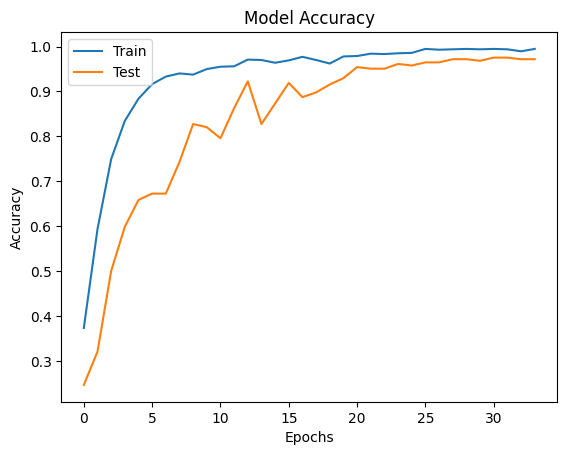

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
!pip install visualkeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 18.1 MB/s eta 0:00:00


In [ ]:
import visualkeras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
import matplotlib.pyplot as plt
import os



/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


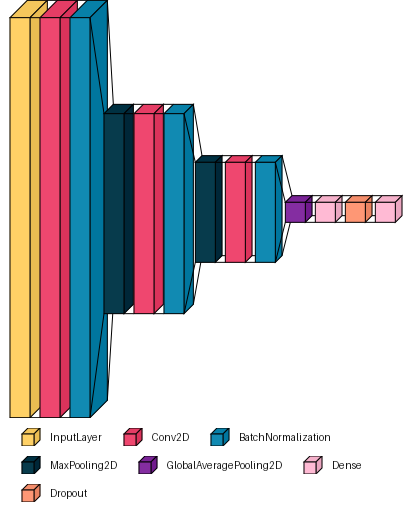

<Figure size 1200x2000 with 0 Axes>

In [ ]:
visualkeras.layered_view(model).show()  # Displays the diagram
plt.figure(figsize=(12, 20))
visualkeras.layered_view(model,legend=True, to_file='model_architecture.png')  # Saves the diagram as an image


In [ ]:
def text_callable(layer_index, layer):
    # Every other piece of text is drawn above the layer, the first one below
    above = bool(layer_index%2)

    # Get the output shape of the layer
    output_shape = [x for x in list(layer.output_shape) if x is not None]

    # If the output shape is a list of tuples, we only take the first one
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variable to store text which will be drawn
    output_shape_txt = ""

    # Create a string representation of the output shape
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 2: # Add an x between dimensions, e.g. 3x3
            output_shape_txt += "x"
        if ii == len(output_shape) - 2: # Add a newline between the last two dimensions, e.g. 3x3 \n 64
            output_shape_txt += "\n"

    # Add the name of the layer to the text, as a new line
    output_shape_txt += f"\n{layer.name}"

    # Return the text value and if it should be drawn above the layer
    return output_shape_txt, above

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


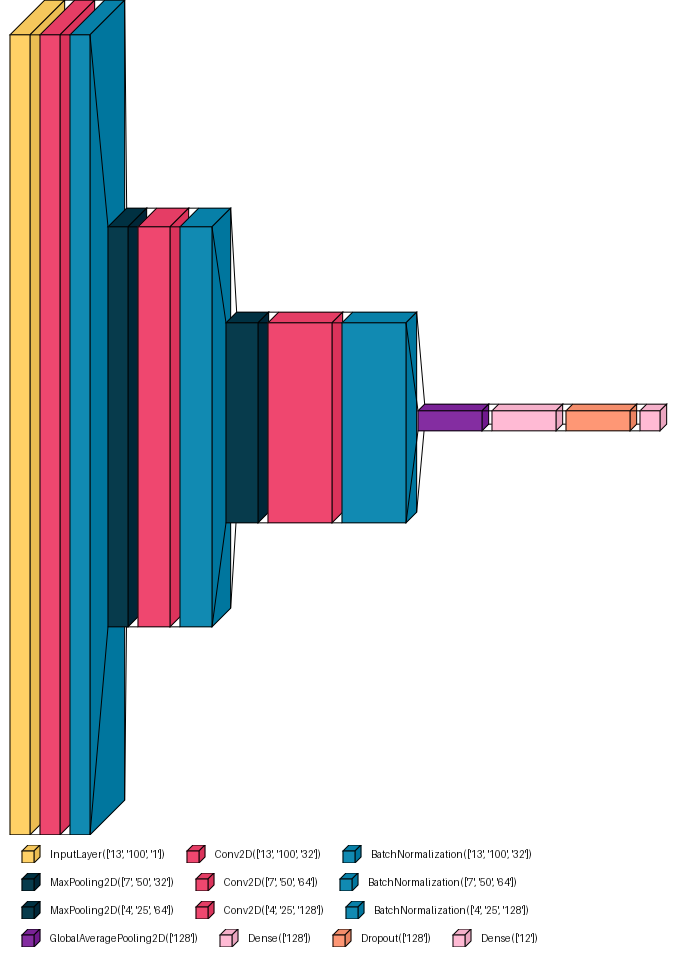

In [ ]:
visualkeras.layered_view(
    model,
    legend=True,             # Add legend for better understanding
    show_dimension=True,     # Display input/output dimensions of layers
    scale_xy=8,             # Adjust horizontal and vertical scaling
    scale_z=0.5,               # Adjust layer depth scaling
    max_z=400                # Set maximum depth
)


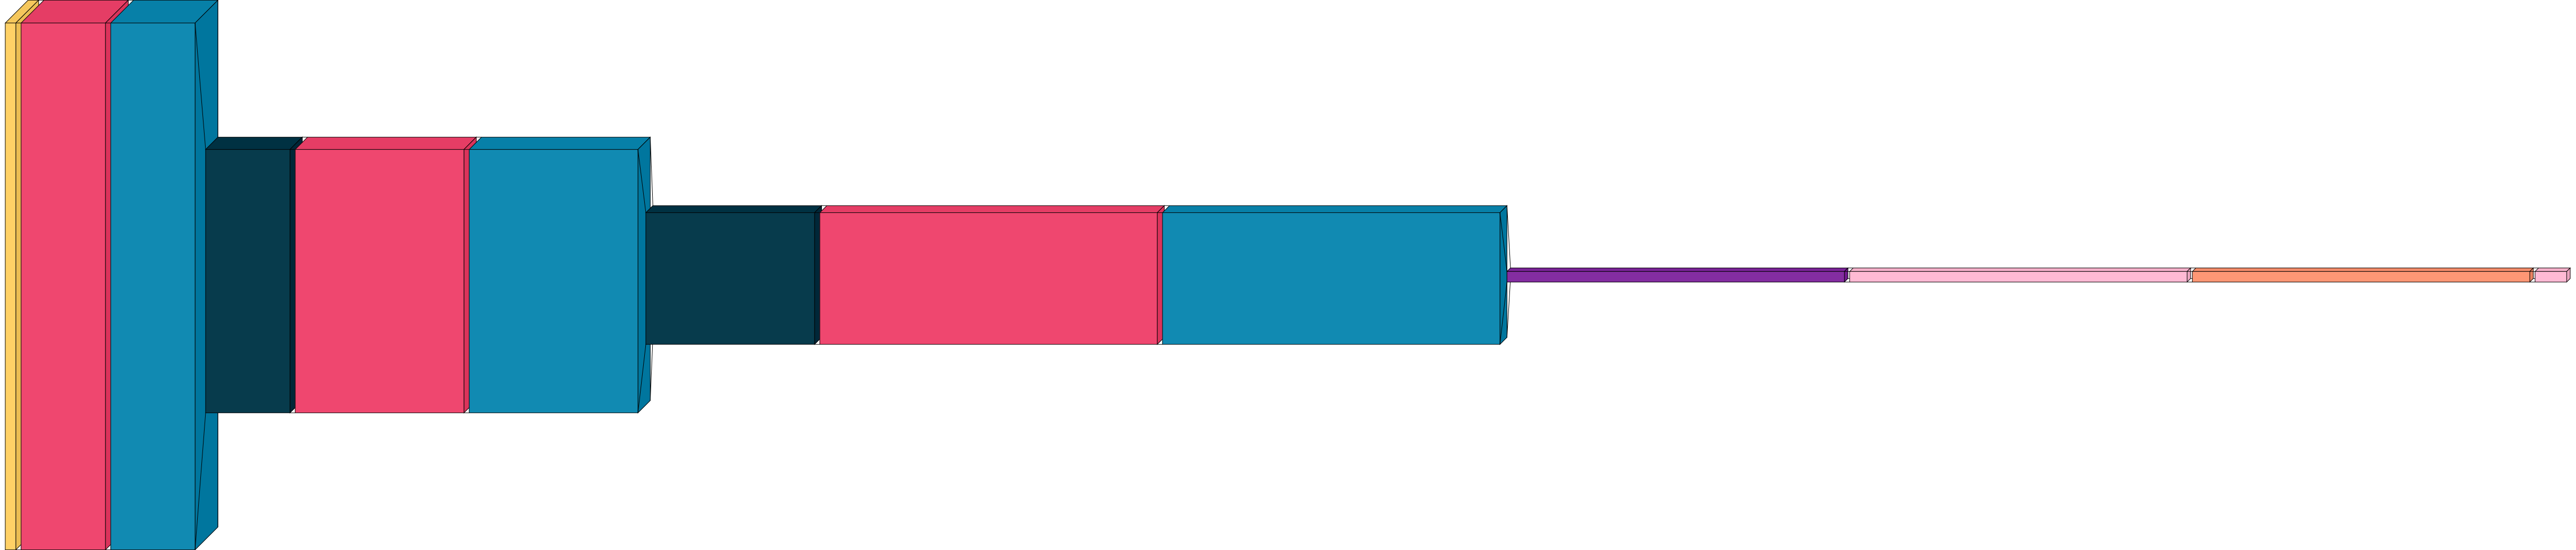

In [ ]:
visualkeras.layered_view(model, scale_xy=10, scale_z=5, max_z=1000)

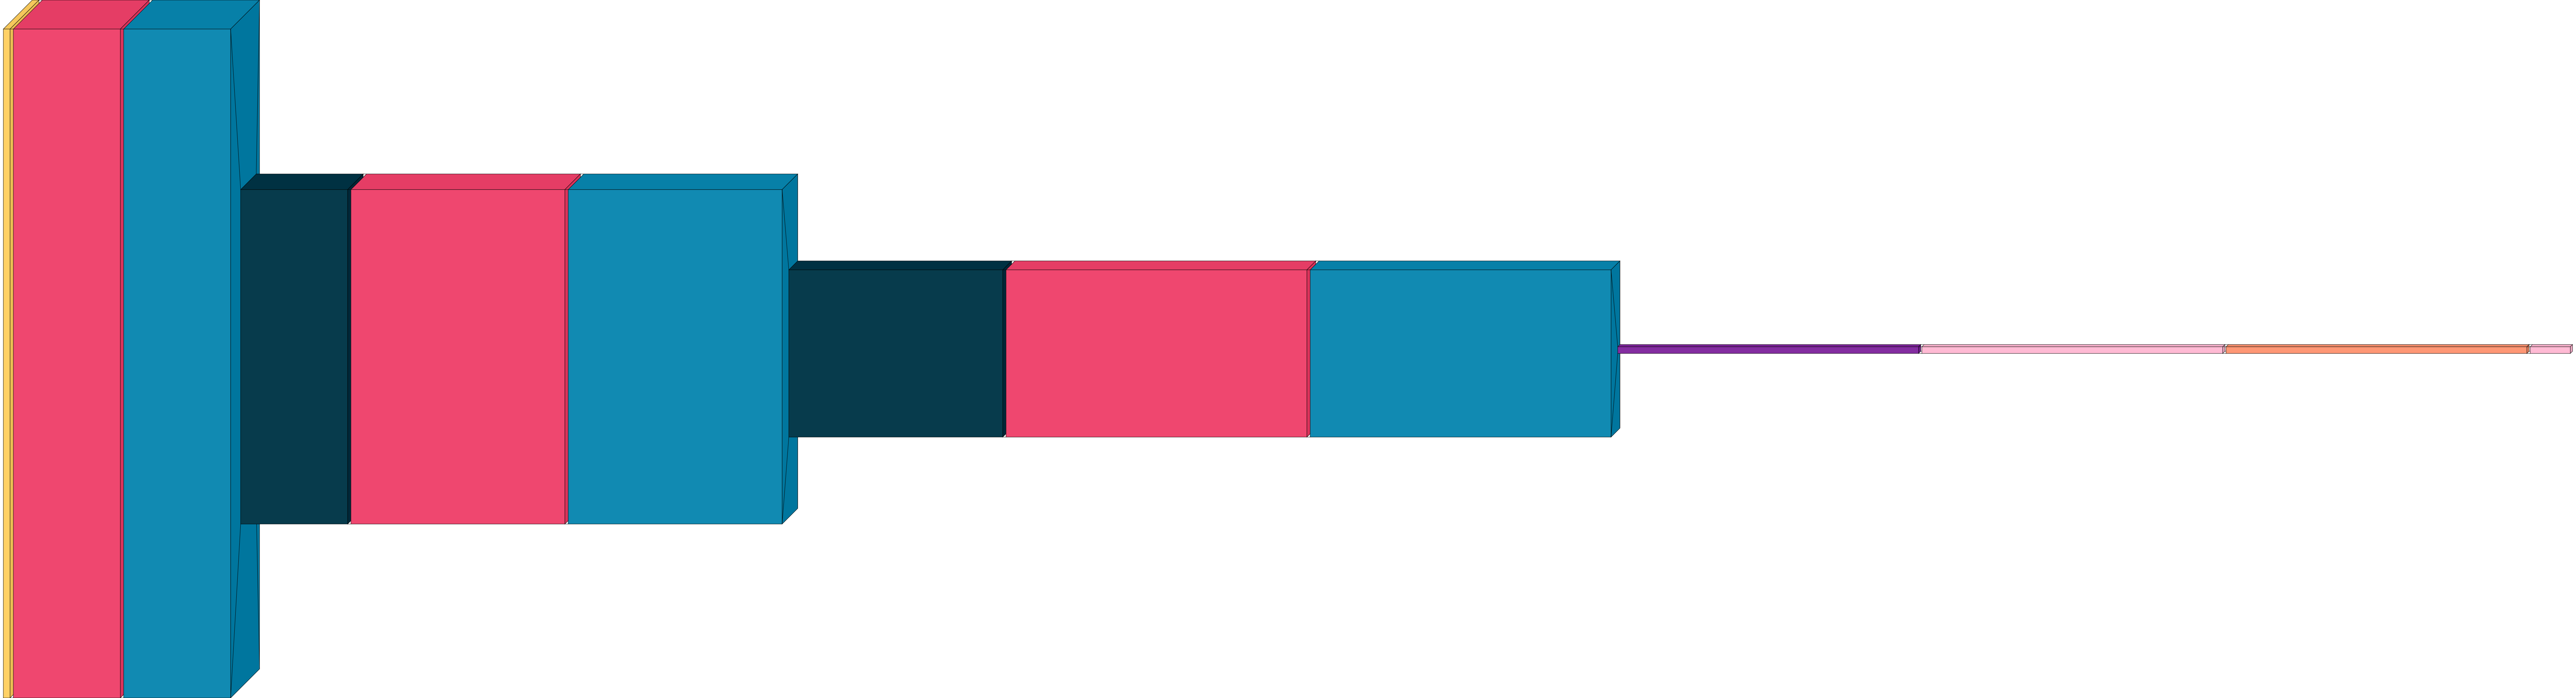

In [ ]:
visualkeras.layered_view(model, scale_xy=20, scale_z=10, max_z=900,)